___imports___

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../../Data/NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
# for linear reg this will be our target
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

## feature engineering

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
# super cool!
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null datetime64[ns, UTC]
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [9]:
my_time = df['pickup_datetime'][0]

In [10]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [11]:
df['hour'] = df['EDTdate'].dt.hour

In [12]:
df['AMorPM'] = np.where(
    df['hour'] < 12, 'AM', 'PM'
)

In [13]:
# wkday wkend
df['weekday'] = df['EDTdate'].dt.strftime('%a')

In [14]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,hour,AMorPM,weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,AM,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,AM,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,AM,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,PM,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,PM,Fri


In [15]:
cat_cols = ['hour','AMorPM','weekday']
cont_cols = [
    'pickup_longitude',
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude',
    'passenger_count',
    'dist_km',
]

In [16]:
y_col = ['fare_amount']

In [17]:
# pandas offers cat.vars to num codes
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [18]:
df['weekday'].head() # THIS IS SO COOL! 

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [19]:
df['AMorPM'].cat.categories

Index(['AM', 'PM'], dtype='object')

In [20]:
df['weekday'].cat.codes[0:9] # these are the numerical codes

0    1
1    2
2    2
3    3
4    0
5    4
6    0
7    4
8    5
dtype: int8

In [21]:
df['weekday'].cat.codes.values # turns into numpy array

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [22]:
hr = df['hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['weekday'].cat.codes.values

In [23]:
# stack them together? as cols
np.stack([hr,ampm,wkdy], axis = 1)

# so 4     0    1    means:
#    hr 4  am   mon

# each row is dif datapoint

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [24]:
# can do it with list comprehension! 'one' line of code
cats = np.stack(
    [df[col].cat.codes.values for col in cat_cols], 
    axis = 1
)

In [25]:
# convert numpy array into tensor
# needed to add the .clone().detach() to the 
cats = torch.from_numpy(cats).clone().detach().to(torch.int64)

In [61]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

In [26]:
conts = np.stack(
    [df[col].values for col in cont_cols],
    axis = 1
)

In [27]:
conts = torch.tensor(
    conts,
    dtype = torch.float
)

In [28]:
# now label into tensor
# watch out for the [[]] shape 
# if not .reshape (-1,1)
torch.tensor(df[y_col].values, dtype=torch.float)

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [29]:
# think about this as one hot encoding categories
# this returns however many distinct categores
# 24 hrs, 2 am/pm, 7 days a week
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [30]:
# we add one incase it is odd. then // to not get a float
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

In [31]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

### tabular model

In [32]:
catz = cats[:2]

In [33]:
# remember that:
#  4     0    1   
#  hr 4  AM   mon
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [34]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])

In [35]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [36]:
# inside the forward method
# FORWARD DATA
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

In [37]:
embeddingz # these are tensors with embeddings


[tensor([[-1.5051, -0.6443, -1.1848,  0.6662,  1.2714, -0.0624,  2.7338,  0.3953,
           0.6091,  0.8942,  0.3929,  1.2818],
         [-0.3677,  0.0746,  0.5013, -0.4407, -0.0707, -0.8320,  1.1875,  1.7904,
          -0.4580,  0.3633, -0.1786, -0.3477]], grad_fn=<EmbeddingBackward>),
 tensor([[0.0951],
         [0.0951]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.4641, -0.6374, -0.6534, -0.2793],
         [ 1.3074, -0.0633,  0.0598,  0.6174]], grad_fn=<EmbeddingBackward>)]

In [38]:
z = torch.cat(embeddingz,1)

In [39]:
z

tensor([[-1.5051, -0.6443, -1.1848,  0.6662,  1.2714, -0.0624,  2.7338,  0.3953,
          0.6091,  0.8942,  0.3929,  1.2818,  0.0951, -0.4641, -0.6374, -0.6534,
         -0.2793],
        [-0.3677,  0.0746,  0.5013, -0.4407, -0.0707, -0.8320,  1.1875,  1.7904,
         -0.4580,  0.3633, -0.1786, -0.3477,  0.0951,  1.3074, -0.0633,  0.0598,
          0.6174]], grad_fn=<CatBackward>)

In [40]:
# pass through drop out
selfembdrop = nn.Dropout(0.4)

In [41]:
z = selfembdrop(z)

In [42]:
z

tensor([[-0.0000, -0.0000, -1.9747,  0.0000,  0.0000, -0.1041,  4.5564,  0.0000,
          1.0152,  1.4903,  0.6549,  2.1363,  0.0000, -0.7736, -1.0624, -1.0889,
         -0.4655],
        [-0.6129,  0.1243,  0.8354, -0.7345, -0.1178, -0.0000,  1.9791,  2.9839,
         -0.0000,  0.0000, -0.2976, -0.5795,  0.1585,  0.0000, -0.1055,  0.0996,
          0.0000]], grad_fn=<MulBackward0>)

In [92]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_szs, n_cont, out_sz, layers, p = 0.5):
        
        # layers = [200, 100, 50]
        
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self,x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont], axis = 1)
        x = self.layers(x)
        return x
        

In [93]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p = .4)

In [94]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [95]:
criterion = nn.MSELoss() # np.sqrt(MSE) --> RMSE
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [96]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [100]:
# DATA SHUFFLED ALREADY
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

# should check for lengths

In [101]:
print(len(cat_train), len(con_train))


48000 48000


In [102]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1
    
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred,y_train))
    losses.append(loss)
    
    if i%10 == 1:
        print(f'epoch: {i} loss is {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print (f'Training took {duration/60} minutes')

epoch: 1 loss is 12.592179298400879
epoch: 11 loss is 11.68846321105957
epoch: 21 loss is 11.113826751708984
epoch: 31 loss is 10.731490135192871
epoch: 41 loss is 10.449636459350586
epoch: 51 loss is 10.235868453979492
epoch: 61 loss is 10.0293550491333
epoch: 71 loss is 9.839812278747559
epoch: 81 loss is 9.626640319824219
epoch: 91 loss is 9.424345970153809
epoch: 101 loss is 9.18592643737793
epoch: 111 loss is 8.888727188110352
epoch: 121 loss is 8.558039665222168
epoch: 131 loss is 8.202766418457031
epoch: 141 loss is 7.813398838043213
epoch: 151 loss is 7.380611896514893
epoch: 161 loss is 6.910585880279541
epoch: 171 loss is 6.435306549072266
epoch: 181 loss is 5.939813137054443
epoch: 191 loss is 5.461806774139404
epoch: 201 loss is 5.041651725769043
epoch: 211 loss is 4.613935947418213
epoch: 221 loss is 4.31432580947876
epoch: 231 loss is 4.048673152923584
epoch: 241 loss is 3.9720306396484375
epoch: 251 loss is 3.8590707778930664
epoch: 261 loss is 3.806466579437256
epoch: 2

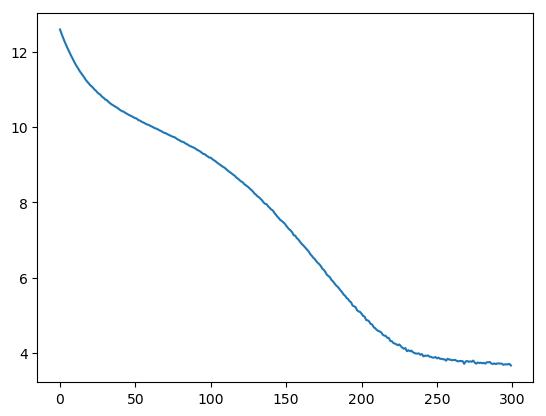

In [103]:
plt.plot(range(epochs), losses)

In [104]:
with torch.no_grad():
    y_val = model(cat_test,con_test)
    
    loss = torch.sqrt(criterion(y_val,y_test))

In [105]:
loss

tensor(3.6553)

In [108]:
for i in range(10):
    
    print(f'PREDICTED {y_val[i].item():8.2f} TRUE: {y_test[i].item():8.2f}')

PREDICTED     7.09 TRUE:     2.90
PREDICTED    19.24 TRUE:     5.70
PREDICTED     7.41 TRUE:     7.70
PREDICTED    10.39 TRUE:    12.50
PREDICTED     5.31 TRUE:     4.10
PREDICTED     4.67 TRUE:     5.30
PREDICTED     4.14 TRUE:     3.70
PREDICTED    16.78 TRUE:    14.50
PREDICTED     3.70 TRUE:     5.70
PREDICTED    10.34 TRUE:    10.10


In [109]:
torch.save(model.state_dict(), 'TaxiModel.pt')